#### 5.2.1 Import the required modules

Several modules will be needed to implement the presented version of the code.

In [1]:
from Notebook import Cell

import sys

from pathlib import Path 

import matplotlib as mpl
import numpy as np

from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm

from borehole_temperature_models.ModelMeasured import ModelMeasured
from borehole_temperature_models.InversionMCMCSimulation import Simulate, DEFAULT_NUM_WALKERS, DEFAULT_NUM_ITERATIONS, DEFAULT_NUM_BURNIN_ITERATIONS
from borehole_temperature_models.TemperatureModel import TemperatureModel
from borehole_temperature_models import Utilities


#### 5.2.2 Create sample content

Initialize the content used to BugBug.

In [2]:
%%time

with Cell(id="content", preserve_as_class=True):
    Bindschadler_Crary_T_profile = np.genfromtxt('Crary Ice RIse borehole measurements from Bindschadler et al 1991/Binschadler_Crary_D_Borehole_Temperatures.csv', delimiter=',', skip_header=1)
    T_interp_Bind = Utilities.rsmpl(Bindschadler_Crary_T_profile[:,0], Bindschadler_Crary_T_profile[:,1], 10)
    Tmeasured = T_interp_Bind[0]
    
    Tsteady_grounded =  np.array(TemperatureModel.Create([470,470], 500, 10, 15e3, 15e3, 0, 0, [-24.2, -24.2], [0.11, 0.11], 800e-4).Tmeasured)
    Tsteady_ice_shelf =  np.array(TemperatureModel.Create([360,360], 500, 10, 15e3, 15e3, 15e3, 0, [-24.2, -24.2], [0.11, 0.11], 800e-4).Tmeasured)

    initial = np.array([400, 500, 0.070, 0.15, -25])

    num_walkers = DEFAULT_NUM_WALKERS
    num_iterations = DEFAULT_NUM_ITERATIONS
    num_burnin_iterations = DEFAULT_NUM_BURNIN_ITERATIONS

    Hr = 500
    Hend = 470
    Hi = 470
    dz = 10
    l = int(Hr/dz) + 1  # Index for ice-bed interface to be used in the loop calculations

    z = np.linspace(-int(Hr), int(Hi), int((Hi + Hr) / dz) + 1)   # Space calculation domain for ice and rock,


CPU times: total: 1.47 s
Wall time: 4.59 s


#### 5.2.3 Simulate new samples and probabilities

In [3]:
%%time

with Cell(
    id="initial_simulation", 
    dependencies="content", 
    preserve_as_class=True,
    preserve_variables=["samples", "probabilities"],
):
    # Set this value to True to force the (re)generation of the samples and probabilities.
    force_generation = False

    samples_filename = 'Inversion MCMC sampling results/samples_Crary_w_iceshelf_narrowed_{initial}_varH_Temp_a_G__tgrounding_Crary_inversion_{walkers}_walkers_{iterations}_iterations.csv'.format(
        initial=content.initial, 
        walkers=content.num_walkers, 
        iterations=content.num_iterations,
    )

    probabilities_filename = 'Inversion MCMC sampling results/probabilities_Crary_w_iceshelf_narrowed_{initial}_varH_Temp_a_G__tgrounding_Crary_inversion_{walkers}_walkers_{iterations}_iterations.csv'.format(
        initial=content.initial, 
        walkers=content.num_walkers, 
        iterations=content.num_iterations,
    )
    
    should_execute = (
        force_generation
        or not Path(samples_filename).is_file()
        or not Path(probabilities_filename).is_file()
    )

    if not should_execute:
        sys.stdout.write("The samples and probabilities already exist.\n")
    else:
        with Utilities.Timer():
            samples, probabilities = Simulate(
                z=content.z,
                Tmeasured=content.Tmeasured,
                Terr=0.05 * np.mean(content.Tmeasured),
                p0=[np.array(content.initial) + 1e-4 * np.random.randn(len(content.initial)) for i in range(content.num_walkers)],
                num_iterations=10, # BugBug content.num_iterations,
                num_burnin_iterations=10, # BugBug content.num_burnin_iterations,
            )
    
        np.savetxt(
            content.samples_filename, 
            samples, 
            delimiter=',',
        )

        np.savetxt(
            content.probabilities_filename, 
            probabilities, 
            delimiter=',',
        )
    
        sys.stdout.write("The samples and probabilities have been saved.\n")
       
    samples = np.loadtxt(samples_filename, delimiter=',')
    probabilities = np.loadtxt(probabilities_filename, delimiter=',')
    

The samples and probabilities already exist.
CPU times: total: 141 ms
Wall time: 395 ms


#### 5.2.4 BugBug: Simulate more content

In [4]:
%%time

with Cell(
    id="second_simulation",
    dependencies="initial_simulation",
    preserve_as_class=True,
    preserve_variables=["index", "lnprobmax", "probmax", "rmslik"],
):
    # Set this value to True to force the (re)generation of the samples and probabilities.
    force_generation = False # BugBug True

    import pickle

    rmslik_filename = Path("rmslik.pickle")

    should_execute = (
        force_generation
        or not rmslik_filename.is_file()
    )

    lnprobmax = -0.8
    
    if should_execute:
        probmax = np.array(initial_simulation.probabilities[(initial_simulation.probabilities>lnprobmax)])

        index = np.random.randint(len(initial_simulation.samples[(initial_simulation.probabilities>lnprobmax)]), size=2000)

        rmslik = [] 

        for i in tqdm(range(len(index))):
            rmslik.append(Utilities.RMS(ModelMeasured(*initial_simulation.samples[(initial_simulation.probabilities>lnprobmax)][index[i]]), content.Tmeasured))

        with rmslik_filename.open("wb") as f:
            pickle.dump((probmax, index, rmslik), f)
    else:
        with rmslik_filename.open("rb") as f:
            probmax, index, rmslik = pickle.load(f)
        
        sys.stdout.write("Loaded pickled data.\n")


Loaded pickled data.
CPU times: total: 0 ns
Wall time: 7.74 ms


#### 5.2.5 BugBug: Display

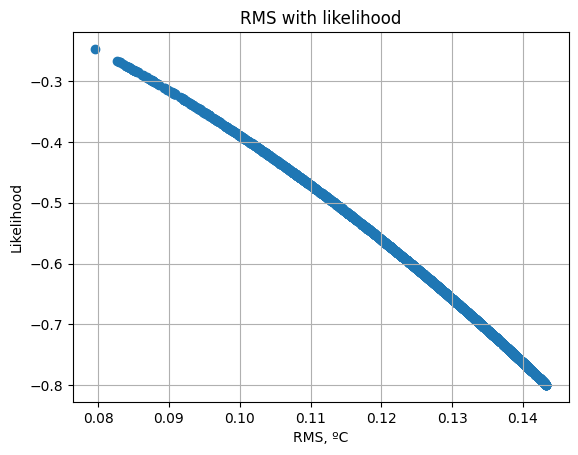

In [5]:
with Cell(dependencies="second_simulation"):
    plt.scatter(second_simulation.rmslik, second_simulation.probmax[second_simulation.index])
    plt.xlabel('RMS, ºC')
    plt.ylabel('Likelihood')
    plt.title('RMS with likelihood')
    plt.grid()

#### 5.2.6 BugBug: Display More

<timed exec>:56: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


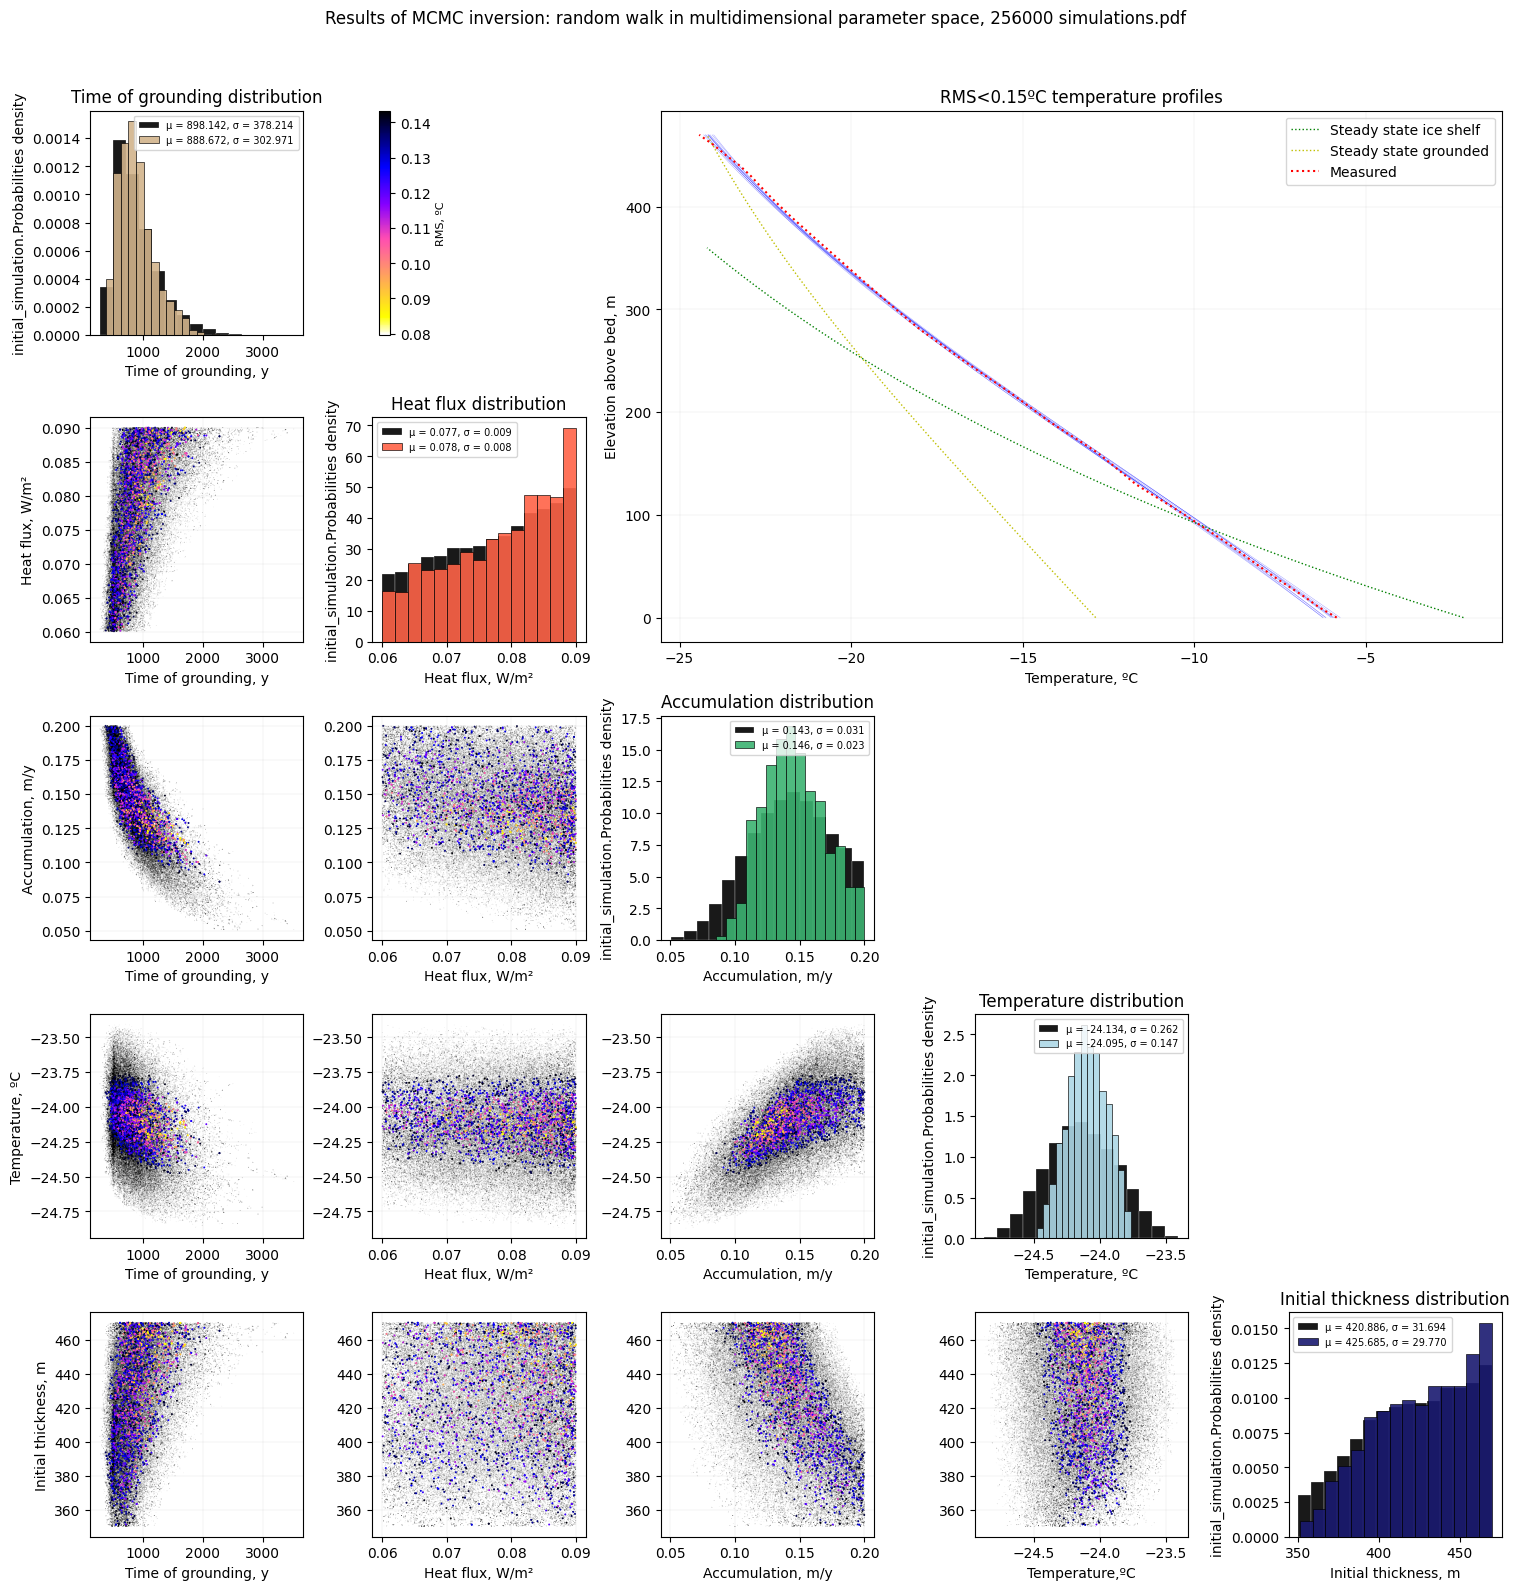

CPU times: total: 2.38 s
Wall time: 8.71 s


In [6]:
%%time

with Cell(dependencies="second_simulation"):
    lnprobmin = -2.5

    hs1 = initial_simulation.samples[(initial_simulation.probabilities>second_simulation.lnprobmax)][:,0][second_simulation.index]
    xs1 = initial_simulation.samples[(initial_simulation.probabilities>second_simulation.lnprobmax)][:,1][second_simulation.index]
    ys1 = initial_simulation.samples[(initial_simulation.probabilities>second_simulation.lnprobmax)][:,2][second_simulation.index]
    zs1 = initial_simulation.samples[(initial_simulation.probabilities>second_simulation.lnprobmax)][:,3][second_simulation.index]
    ts1 = initial_simulation.samples[(initial_simulation.probabilities>second_simulation.lnprobmax)][:,4][second_simulation.index]
    hs = initial_simulation.samples[(initial_simulation.probabilities>lnprobmin)][:,0]
    xs = initial_simulation.samples[(initial_simulation.probabilities>lnprobmin)][:,1]
    ys = initial_simulation.samples[(initial_simulation.probabilities>lnprobmin)][:,2]
    zs = initial_simulation.samples[(initial_simulation.probabilities>lnprobmin)][:,3]
    ts = initial_simulation.samples[(initial_simulation.probabilities>lnprobmin)][:,4]


    fig = plt.figure(figsize=(15, 15), constrained_layout=True)

    fig.suptitle('Results of MCMC inversion: random walk in multidimensional parameter space, {:0.0f} simulations.pdf'.format(len(initial_simulation.samples)), y=1.05)

    gs = GridSpec(5, 5, figure=fig)

    # Temperature profiles
    sub = fig.add_subplot(gs[0:2, 2:5])

    for theta in (initial_simulation.samples[(initial_simulation.probabilities>second_simulation.lnprobmax)])[np.random.randint(len(initial_simulation.samples[(initial_simulation.probabilities>second_simulation.lnprobmax)]), size=10)]:
        sub.plot(ModelMeasured(*theta), content.z[content.l-1:], 'b', linewidth=0.25, alpha=0.5)

    sub.set_title('RMS<0.15ºC temperature profiles')
    sub.set_xlabel('Temperature, ºC')
    sub.set_ylabel('Elevation above bed, m')

    sub.plot(content.Tsteady_ice_shelf[content.l-1:], content.z[content.l-1:-11], 'g:', linewidth=1, label='Steady state ice shelf')
    sub.plot(content.Tsteady_grounded[content.l-1:], content.z[content.l-1:], 'y:', linewidth=1, label='Steady state grounded')
    sub.plot(content.Tmeasured, content.z[content.l-1:],'r:', linewidth=1.5,  label='Measured')

    sub.grid(linestyle='-', linewidth=0.1)

    sub.legend()

    # Common plots
    def AddScatterSubplot(
        grid_spec_loc,
        x_label,
        y_label,
        x1_values,
        y1_values,
        x2_values,
        y2_values,
    ):
        sub = fig.add_subplot(grid_spec_loc)

        for x_values, y_values, c, s, alpha in [
            (x1_values, y1_values, 'k', 0.5, 0.05),
            (x2_values, y2_values, second_simulation.rmslik, 2, 1),
        ]:
            scatter = sub.scatter(
                x_values, 
                y_values,
                c=c,
                s=s,
                alpha=alpha,
                edgecolors='none',
                cmap='gnuplot2_r',
            )

        sub.grid(linestyle='-', linewidth=0.1)

        sub.set_xlabel(x_label)

        if y_label is not None:
            sub.set_ylabel(y_label)

        return scatter

    for args in [
        (gs[1, 0], 'Time of grounding, y', 'Heat flux, W/m²',      xs, ys, xs1, ys1),
        (gs[2, 0], 'Time of grounding, y', 'Accumulation, m/y',    xs, zs, xs1, zs1),
        (gs[2, 1], 'Heat flux, W/m²',       None,                  ys, zs, ys1, zs1),
        (gs[3, 0], 'Time of grounding, y', 'Temperature, ºC',      xs, ts, xs1, ts1),
        (gs[3, 1], 'Heat flux, W/m²',      None,                   ys, ts, ys1, ts1),
        (gs[3, 2], 'Accumulation, m/y',    None,                   zs, ts, zs1, ts1),
        (gs[4, 0], 'Time of grounding, y', 'Initial thickness, m', xs, hs, xs1, hs1),
        (gs[4, 1], 'Heat flux, W/m²',      None,                   ys, hs, ys1, hs1),
        (gs[4, 2], 'Accumulation, m/y',    None,                   zs, hs, zs1, hs1),
        (gs[4, 3], 'Temperature,ºC',       None,                   ts, hs, ts1, hs1),
    ]:
        scatter_content = AddScatterSubplot(*args)

    def AddHistSubplot(
        grid_spec_loc,
        title,
        x_label,
        secondary_color,
        primary_values,
        secondary_values,
    ):
        sub = fig.add_subplot(grid_spec_loc)

        for values, facecolor, edgecolor, linewidth in [
            (primary_values, "black", "white", 0.2),
            (secondary_values, secondary_color, "black", 0.5),
        ]:
            sub.hist(
                values,
                15, 
                density=True,
                facecolor=facecolor,
                edgecolor=edgecolor,
                alpha=0.9,
                linewidth=linewidth,
                label="\u03bc = {:0.3f}, \u03C3 = {:0.3f}".format(np.mean(values), np.std(values)),
            )

        sub.set_title(title)
        sub.set_xlabel(x_label)
        sub.set_ylabel("initial_simulation.Probabilities density")
        sub.legend(borderpad=0.5, prop={"size": 7})

    for args in [
        (gs[0, 0], 'Time of grounding distribution', 'Time of grounding, y', "tan",            xs, xs1),
        (gs[1, 1], 'Heat flux distribution',         'Heat flux, W/m²',      "tomato",         ys, ys1),
        (gs[2, 2], 'Accumulation distribution',      'Accumulation, m/y',    "mediumseagreen", zs, zs1),
        (gs[3, 3], 'Temperature distribution',       'Temperature, ºC',      "lightblue",      ts, ts1),
        (gs[4, 4], 'Initial thickness distribution', 'Initial thickness, m', "midnightblue",   hs, hs1),
    ]:
        AddHistSubplot(*args)

    # Colorbar
    sub = fig.add_subplot(gs[0, 1])
    
    fig.colorbar(
        scatter_content,
        ax=sub, 
        orientation="vertical", 
        pad=-1.0,
    ).set_label('RMS, ºC',weight = 'light',size = 8)
    
    sub.xaxis.set_visible(False)
    sub.yaxis.set_visible(False)
    sub.axis("off")
    
    plt.show()
